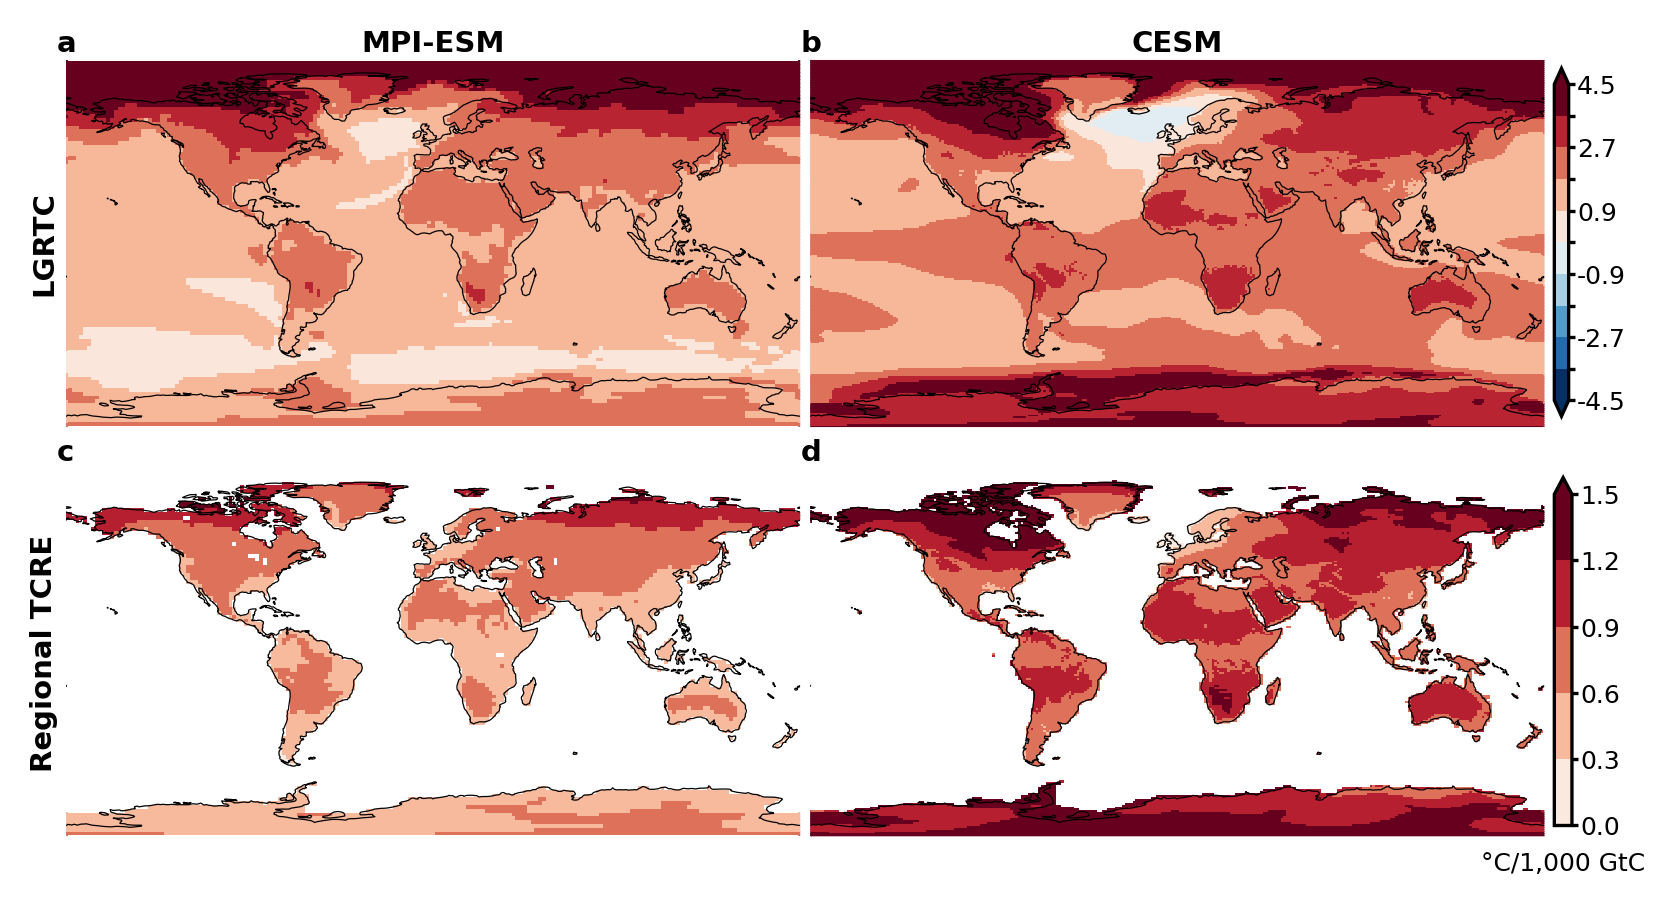

绘图完成，结果已保存到 /scratch/b/b380949/NC-FigS8_TCRE.pdf
文件大小: 2.43 MB


In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from matplotlib import rcParams
import matplotlib.cm as cm
import os
import numpy as np

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 7

models = ['MPI-ESM', 'CESM']
variables = ['slope', 'tas_tcre']
variable_labels = ['LGRTC', 'Regional TCRE']

# Original bounds
bounds_a = [-4.5, -3.6, -2.7, -1.8, -0.9, 0, 0.9, 1.8, 2.7, 3.6, 4.5]
bounds_b = [-1.5, -1.2, -0.9, -0.6, -0.3, 0, 0.3, 0.6, 0.9, 1.2, 1.5]

norm_a = BoundaryNorm(bounds_a, ncolors=256)
norm_b = BoundaryNorm(bounds_b, ncolors=256)

# Create full RdBu_r colormap used for a,b plots
def create_10level_cmap():
    cmap = cm.get_cmap('RdBu_r')
    colors = [cmap(i)[:3] for i in [0, 28, 56, 85, 113, 143, 170, 198, 226, 255]]
    return LinearSegmentedColormap.from_list('10level_cmap', colors, N=256)

# Create a 5-level red colormap for c,d plots (only positive values)
def create_red_cmap():
    # Use the red colors from RdBu_r positive side (approximately from midpoint 0.5 to 1)
    full_cmap = cm.get_cmap('RdBu_r')
    # Select 5 points from 0.5 to 1.0 in RdBu_r (red shades increasing)
    reds = [full_cmap(x)[:3] for x in np.linspace(0.55, 1.0, 5)]
    return LinearSegmentedColormap.from_list('red_only_cmap', reds, N=256)

cm_var = 1 / 2.54
fig_width = 16.5 * cm_var
fig_height = 9 * cm_var  # a bit taller for colorbars

fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)

# 2 rows, 2 columns + right side colorbar per row → total 2 rows, 3 columns
gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 0.03], wspace=0.02, hspace=0)

axes = []
panel_labels = list("abcd")
panel_idx = 0

for row in range(2):
    row_axes = []
    for col in range(2):
        ax = fig.add_subplot(gs[row, col], projection=ccrs.PlateCarree())
        ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
        ax.coastlines(linewidth=0.3)
        ax.set_frame_on(False)
        fig.text(ax.get_position().x0 - 0.005, ax.get_position().y1 + 0.002,
                 panel_labels[panel_idx], fontsize=7, fontweight='bold',
                 ha='left', va='bottom')
        panel_idx += 1
        row_axes.append(ax)
    axes.append(row_axes)

cbar_axes = [fig.add_subplot(gs[row, 2]) for row in range(2)]

for i, model in enumerate(models):
    axes[0][i].set_title(model, fontsize=7, fontweight='bold', pad=2)

for i, label in enumerate(variable_labels):
    axes[i][0].text(-0.03, 0.5, label, transform=axes[i][0].transAxes,
                    fontsize=7, fontweight='bold', ha='center', va='center',
                    rotation=90)

def draw_colorbar_ab(cax, norm, cmap, bounds):
    # For a,b: full bounds and colormap, no units
    cb = plt.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=cax, orientation='vertical', ticks=bounds,
        spacing='proportional', extend='both'
    )
    tick_labels = [f"{b:.1f}" if i % 2 == 0 else "" for i, b in enumerate(bounds)]
    cb.ax.set_yticklabels(tick_labels)
    cb.ax.tick_params(labelsize=6, direction='out', length=1.5, pad=0.5)
     # 控制 colorbar 的宽度，例如压缩到 40%
    pos = cax.get_position()
    cax.set_position([pos.x0, pos.y0+0.03, pos.width * 0.65, pos.height * 0.85])

    
    # No unit label for a,b
    return cb

def draw_colorbar_cd(cax, cmap, bounds_pos):
    """
    Draw colorbar only for positive part from 0, 
    0 side flat (no extension), top side triangular (extend 'max'),
    ticks and labels only for positive values.
    Colorbar label is "°C per 1000 GtC" (using Unicode for degree and a space).
    """
    # Custom norm for positive values only
    norm = BoundaryNorm(bounds_pos, ncolors=256, clip=False)

    # Draw colorbar with extend='max' to show a triangular arrow on top
    cb = plt.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=cax, orientation='vertical',
        ticks=bounds_pos,
        spacing='proportional',
        extend='max'
    )
    # Only label ticks at 0 and above
    tick_labels = [f"{b:.1f}" for b in bounds_pos]
    cb.ax.set_yticklabels(tick_labels)
    cb.ax.tick_params(labelsize=6, direction='out', length=1.5, pad=0.5)
    # 控制 colorbar 的宽度，例如压缩到 40%
    pos = cax.get_position()
    cax.set_position([pos.x0, pos.y0+0.03, pos.width * 0.8, pos.height * 0.85])

    
    # Remove the 'extend' triangle on bottom side by hiding it via spines
    # The colorbar bottom end is flat by default when extend='max'
    # The triangle appears only on max side, which is top.

    cax.text(0.5, -0.08, "°C/1,000 GtC", transform=cax.transAxes,
             ha='center', va='top', fontsize=6)

    return cb

# Define positive bounds for c,d colorbars starting at 0
# Extract only the positive part (including 0) from bounds_a and bounds_b
bounds_a_pos = [b for b in bounds_a if b >= 0]  # [0, 0.9, 1.8, 2.7, 3.6, 4.5]
bounds_b_pos = [b for b in bounds_b if b >= 0]  # [0, 0.3, 0.6, 0.9, 1.2, 1.5]

red_cmap = create_red_cmap()
full_cmap = create_10level_cmap()

for row, var in enumerate(variables):
    for col, model in enumerate(models):
        ds = xr.open_dataset(f'/work/bm1147/b380949/web-monitoring/secP/rtcre_sope/rtcre_{model}_ELUC2tas.nc')
        data = ds[var] #.isel(time=0)
        ax = axes[row][col]

        if row == 0:  # a,b plots: full diverging cmap, full norm
            norm = norm_a
            cmap = full_cmap
            im = ax.pcolormesh(data.lon, data.lat, data,
                               transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
        else:  # c,d plots: positive-only colormap, positive-only norm
            # clip negative values to 0 for visualization
            #data_pos = data.where(data >= 0, 0)
            data_pos = data.where(data <1000)
            
    # 设置 cmap 的 bad 值为白色（用于 NaN 区域）
            #import copy
            #red_cmap_white = copy.copy(red_cmap).with_extremes(bad='white')

    # 设置 cmap 的 bad 值为白色，用于显示 NaN（如海洋区域）
           # red_cmap = red_cmap.with_extremes(bad='white')  # matplotlib >= 3.2
                    # Create norm only for positive bounds
            norm_pos = BoundaryNorm(bounds_b_pos, ncolors=256)

            im = ax.pcolormesh(data.lon, data.lat, data_pos,
                               transform=ccrs.PlateCarree(), cmap=red_cmap, norm=norm_pos)

    # Draw colorbars
    if row == 0:
        draw_colorbar_ab(cbar_axes[row], norm_a, full_cmap, bounds_a)
    else:
        draw_colorbar_cd(cbar_axes[row], red_cmap, bounds_b_pos)

#output_path = '/work/bm1147/b380949/web-monitoring/secP/rtcre_sope/FigS8_TCRE.jpg'
output_path = '/scratch/b/b380949/NC-FigS8_TCRE.pdf'
plt.savefig(output_path, bbox_inches='tight', format='pdf', dpi=300)
plt.show()
plt.close()

print(f"绘图完成，结果已保存到 {output_path}")
print(f"文件大小: {os.path.getsize(output_path) / (1024 * 1024):.2f} MB")
